# This is a showcase of the Xsimlab/GEKKO core processes utilized in Phydra v1


In [1]:
from gekko import GEKKO
import xsimlab as xs
import numpy as np

# to create dynamic storage of fluxes, state variables and forcings
from collections import defaultdict

# to measure process time
import time as tm

# GEKKO backend

In [2]:
@xs.process
class GekkoCore:
    """this object contains the backend GEKKO solver and is modified or read by all other processes"""
    
    m = xs.any_object(description='GEKKO model instance is stored here')
    
    def initialize(self):
        print('initializing model core')
        self.m = GEKKO(remote=False, name='phydra')
        
        # add defaultdict of list that dynamically stores fluxes by component label
        self.m.phydra_fluxes = defaultdict(list)
        # same for state variables
        self.m.phydra_SVs = defaultdict()
        # same for forcings
        self.m.phydra_forcings = defaultdict()
        
    def finalize(self):
        print('finalizing gekko core: cleanup')
        #self.m.open_folder()
        self.m.cleanup()

        
@xs.process
class GekkoContext:
    """ Inherited by all other model processes to access GekkoCore"""
    m = xs.foreign(GekkoCore, 'm')

@xs.process
class Solver(GekkoContext):
    solver_type = xs.variable(intent='out')
    
@xs.process
class GekkoSequentialSolve(Solver):
    """takes time from Time process, needs to be added to model"""
    
    def initialize(self):
        self.solver_type = 'seq'
        
    def finalize_step(self):
        #print(self.m.__dict__)
        
        print([i.name for i in self.m._variables])
        print('Running solver now')
        
        # add solver options
        self.m.options.REDUCE = 3  # handles reduction of larger models, have not benchmarked it yet
        self.m.options.NODES = 3  # improves solution accuracy
        self.m.options.IMODE = 7  # sequential dynamic solver

        solve_start = tm.time()
        self.m.solve(disp=False)  # use option disp=True to print gekko output
        solve_end = tm.time()

        print(f"Model was solved in {round(solve_end-solve_start,2)} seconds")
        #print(self.m.__dict__)
        
        
@xs.process
class Time(GekkoContext):
    
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    time = xs.index(dims='time', description='time in days')

    def initialize(self):
        print('Initializing Model Time')
        self.time = self.days

        # ASSIGN MODEL SOLVING TIME HERE:
        self.m.time = self.time
        
        # add state variable keeping track of time within model (for time-dependent functions):
        self.m.phydra_SVs['time'] = self.m.Var(0, lb=0, name='time')
        self.m.Equation(self.m.phydra_SVs['time'].dt() == 1)

# State Variables

Custom state variables can be written as processes inheritng from the state variable base class (if they contain a single state variable).

Additionally the FunctionalGroup process allows a user to initialize a group of state variables of variable number that share common fluxes, just with different parameters (this can be achieved by special parameter init processes). There is also a functional group base class that can be subclassed for custom written functionl group-like processes, of there however there can only be one subclass initialized per model instance.

In [3]:
@xs.process
class StateVariable(GekkoContext):
    """ this process creates a single state variable with user specified label in our model """
    label = xs.variable(intent='out')
    
    value = xs.variable(intent='out', dims='time', description='stores the value of component state variable')
    SV = xs.any_object(description='stores the gekko variable')
    
    initVal = xs.variable(intent='in', description='initial value of component')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"state variable {self.label} is initialized")
        
        # store GEKKO SV object in Gekko context self.m
        self.m.phydra_SVs[self.label] = self.m.SV(self.initVal, name=self.label, lb=0)
        self.value = self.m.phydra_SVs[self.label].value
    
    def run_step(self):
        print('assembling Equations')
        print(self.m.phydra_fluxes)
        self.m.Equation(
            self.m.phydra_SVs[self.label].dt() == sum([flux for flux in self.m.phydra_fluxes[self.label]])
        )

In [4]:
class FunctionalGroup(GekkoContext):
    """ creates array of state variables """
    
    label = xs.variable(intent='out', description='the label supplied at model initialisation')
    value = xs.variable(intent='out', dims=('not_initalized', 'time'), description='stores output in dimensions supplied to process_setup')
    
    num = xs.variable(intent='in', description='number of state variables within group')
    initVal = xs.variable(intent='inout', description='initial value of component')
    
    SV = xs.any_object(description='stores the gekko variable')
    
    # Simulation stages
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"functional group {self.label} is initialized with size {self.num}")
        
        self.create_index()
        
        self.m.phydra_SVs[self.label] = np.array([self.m.SV(name=f"{self.label}_{i}", value=self.initVal, lb=0) for i in range(self.num)])
        self.value = [sv.value for sv in self.m.phydra_SVs[self.label]]
        
    def run_step(self):
        print(f"assembling Equations for {self.label}")

        gk_array = self.m.phydra_SVs[self.label]
        fluxes = self.m.phydra_fluxes[self.label]
        for i in range(self.num):
            self.m.Equation(gk_array[i].dt() == sum([flux[i] for flux in fluxes]))
    
    # Helper functions
    def create_index(self):
        # this creates numbered index with label:
        if self.num == 1:
            index_list = [f"{self.label}"]
        else:
            index_list = [f"{self.label}-{i}" for i in range(self.num)]
        setattr(self, self.label, index_list)
    
    @classmethod
    def setup(cls, dim_label):
        """ create copy of process class with user specified name and dimension label """
        new_cls = type(cls.__name__ + dim_label, cls.__bases__, dict(cls.__dict__))
        # add new index with variable name of label (to avoid Zarr storage conflicts)
        new_dim = xs.index(dims=dim_label, groups='comp_index')
        setattr(new_cls, dim_label, new_dim)
        # modify dimensions 
        new_cls.value.metadata['dims'] = ((dim_label, 'time'),)
        # return intialized xsimlab process
        return xs.process(new_cls)

# Fluxes

Fluxes are processes that define functions actiong on state variable (and functional groups) that make up the model. These can be forcing, loss or exchange fluxes defined in different types of processes. These be defined as python functions of defined state variables and can draw on a seperate FunctionLibrary module where common type of equation used in marine ecosystem models are defined. 

In [5]:
# a function to randomly generate simple string as label for 
# xsimlab dimension that should be flexible (scalar or list)
# dependent on the SV label passed to the flux

    # TODO: this should be handled better, either by wrapping the call 
    # to xs.create_setup() to automatically share commond dimension labels
    # or otherwise changing the interface or process refactoring structure
    
import string
import random

def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [6]:
class FunctionLibrary:
    """ This is the basic structure of the library of functions
    thanks to numpy vectorization these can be used with functional group interactions as well
    """
    def monod(Resource, Consumer, halfsat = 0.5):
        print(type(Resource), type(Consumer), type(halfsat))
        return Resource / (halfsat + Resource) * Consumer
    
    
# Some basic fluxes
@xs.process
class GrowthFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    resource_label = xs.variable(intent='in')
    consumer_label = xs.variable(intent='in')
    halfsat = xs.variable(intent='in', description='half saturation constant')
    
    #flex dim input:
    #components = xs.variable(intent='in', dims=id_generator())
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.consumer_label} consuming {self.resource_label} is initialized")
        
        self.resource = self.m.phydra_SVs[self.resource_label]
        self.consumer = self.m.phydra_SVs[self.consumer_label]
        
        self.halfsat_par = self.m.Param(self.halfsat, name='halfsat')
        
        flux = FunctionLibrary.monod(self.resource, self.consumer, self.halfsat_par)
        print(flux)
        self.value = self.m.Intermediate(flux, name='monod').value
        
        self.m.phydra_fluxes[self.resource_label].append(-flux)
        self.m.phydra_fluxes[self.consumer_label].append(flux)
        

@xs.process
class GrowthMultiFlux(GekkoContext):
    """ Functional Group growing on single ressource """
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims=(id_generator(), 'time'))
    
    resource_label = xs.variable(intent='in')
    consumer_label = xs.variable(intent='in')
    halfsat = xs.variable(intent='inout', description='half saturation constant')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.consumer_label} consuming {self.resource_label} is initialized")
        
        self.resource = np.array([self.m.phydra_SVs[self.resource_label]])
        self.consumer = self.m.phydra_SVs[self.consumer_label]
        
        self.halfsat_par = np.array([self.m.Param(self.halfsat, name='multi-halfsat')])
        
        fluxes = FunctionLibrary.monod(self.resource, self.consumer, self.halfsat_par)
        
        print(fluxes)
        
        self.value = [self.m.Intermediate(flux).value for flux in fluxes]
        #self.value = np.array([self.m.Intermediate(fluxes[i], name=f"monod{i}").value for i in range(len(fluxes))], dtype='object')
        
        print('VALUE fg', self.value)
        
        self.m.phydra_fluxes[self.resource_label].append(-sum(fluxes))
        self.m.phydra_fluxes[self.consumer_label].append(fluxes)


@xs.process
class Forcing(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    initVal = xs.variable(intent='in')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"forcing {self.label} is initialized")
        
        self.m.phydra_forcings[self.label] = self.m.Param(self.initVal, name=self.label)
        self.value = self.m.phydra_forcings[self.label].value
    
    
@xs.process
class InFlux(GekkoContext):
    label = xs.variable(intent='out')
    value = xs.variable(intent='out', dims='time')
    
    forcing_label = xs.variable(intent='in')
    SV_label = xs.variable(intent='in')
    
    flowrate = xs.variable(intent='in', description='half saturation constant')
    
    def initialize(self):
        self.label = self.__xsimlab_name__
        print(f"flux {self.label} of {self.forcing_label} flowing to {self.SV_label} is initialized")
        
        self.forcing = self.m.phydra_forcings[self.forcing_label]
        
        self.flowrate_par = self.m.Param(self.flowrate, name='flowrate')
        
        flux = self.flowrate * self.forcing
        
        self.value = self.m.Intermediate(flux, name='influx').value
        
        self.m.phydra_fluxes[self.SV_label].append(flux)

# Flexible dimensionality process parameter initialisation

This is still more of a prototype. With the flexible initialisation of functionl groups, the parameterisation get's more complex. There could be solutions outside of xsimlab, or internal through custom processes.

e.g.:
function call of phydra.allometry() class to pass parameter in appropriate dims, storing Size, as well as allometry functions outside of xsimlab structure

or
passing parameters to created fluxes from separately initialized ParameterSetup process, and passing parameters as xs.foreign(intent='out)

In [7]:
@xs.process
class ParameterSetup:
    parameter = xs.foreign(GrowthMultiFlux, 'halfsat', intent='out')
    
    num = xs.foreign(GrowthMultiFlux, 'halfsat')
    
    def initialize(self):
        self.parameter = 0.5

# Model creation

In [8]:
MODEL = xs.Model({'core':GekkoCore, 
                  'solver':GekkoSequentialSolve, 
              
                  'time':Time, 
              
                  'N':StateVariable, 
                  'P':FunctionalGroup.setup('P'), # same label needs to be supplied for now (todo)
                  
                  'growth':GrowthMultiFlux,
                  
                  'N0':Forcing,
                  
                  'N_influx':InFlux,
                  
                  'param':ParameterSetup
                 })

MODEL

<xsimlab.Model (9 processes, 10 inputs)>
core
solver
time
    days               [in] ('time',) time in days
N
    initVal            [in] initial value of component
P
    num                [in] number of state variables within group
    initVal         [inout] initial value of component
param
growth
    resource_label     [in]
    consumer_label     [in]
N0
    initVal            [in]
N_influx
    flowrate           [in] half saturation constant
    forcing_label      [in]
    SV_label           [in]

In [26]:
in_ds = xs.create_setup(model=MODEL,
                        clocks={'clock': [0,1]},
                        input_vars={
                            'time__days': ('time', np.arange(0, 10, .1)),
                            
                            'N':{'initVal':1},

                            'P':{'num':5,
                                'initVal':.01},
                            
                            'growth':{'resource_label':'N',
                                      'consumer_label':'P'},                                     
                            
                            'N_influx':{'flowrate':0.5,
                                        'forcing_label':'N0',
                                        'SV_label':'N'},
                            
                            'N0':{'initVal':1}
                        
                        },
                        output_vars={
                            'N__value':None,
                            'P__value':None,
                            'growth__value':None
                        
                        })

In [27]:
with MODEL:
    out_ds = in_ds.xsimlab.run()

initializing model core
Initializing Model Time
state variable N is initialized
functional group P is initialized with size 5
flux growth of P consuming N is initialized
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[((((n)/((multi_halfsat+n))))*(p_0)) ((((n)/((multi_halfsat+n))))*(p_1))
 ((((n)/((multi_halfsat+n))))*(p_2)) ((((n)/((multi_halfsat+n))))*(p_3))
 ((((n)/((multi_halfsat+n))))*(p_4))]
VALUE fg [0, 0, 0, 0, 0]
forcing N0 is initialized
flux N_influx of N0 flowing to N is initialized
assembling Equations
defaultdict(<class 'list'>, {'N': [(-(((((0+((((n)/((multi_halfsat+n))))*(p_0)))+((((n)/((multi_halfsat+n))))*(p_1)))+((((n)/((multi_halfsat+n))))*(p_2)))+((((n)/((multi_halfsat+n))))*(p_3)))+((((n)/((multi_halfsat+n))))*(p_4)))), ((0.5)*(n0))], 'P': [array([((((n)/((multi_halfsat+n))))*(p_0)),
       ((((n)/((multi_halfsat+n))))*(p_1)),
       ((((n)/((multi_halfsat+n))))*(p_2)),
       ((((n)/((multi_halfsat+n))))*(p_3)),
       ((((n)/((multi_half

In [28]:
out_ds

<xarray.Dataset>
Dimensions:                  (IFFVJV: 5, P: 5, clock: 2, time: 100)
Coordinates:
  * P                        (P) <U3 'P-0' 'P-1' 'P-2' 'P-3' 'P-4'
  * clock                    (clock) int64 0 1
  * time                     (time) float64 0.0 0.1 0.2 0.3 ... 9.6 9.7 9.8 9.9
Dimensions without coordinates: IFFVJV
Data variables:
    N0__initVal              int64 1
    N__initVal               int64 1
    N__value                 (time) float64 1.0 1.047 1.093 ... 0.04672 0.04628
    N_influx__SV_label       <U1 'N'
    N_influx__flowrate       float64 0.5
    N_influx__forcing_label  <U2 'N0'
    P__initVal               float64 0.01
    P__num                   int64 5
    P__value                 (P, time) float64 0.01 0.01069 ... 1.181 1.191
    growth__consumer_label   <U1 'P'
    growth__resource_label   <U1 'N'
    growth__value            (IFFVJV, time) float64 0.006667 0.007237 ... 0.1009
    time__days               (time) float64 0.0 0.1 0.2 0.3 ... 9.6 9.7 9.8 9.9

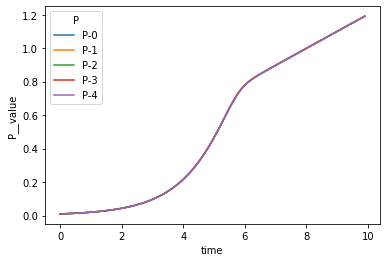

In [29]:
out_ds.P__value.plot.line(x='time')

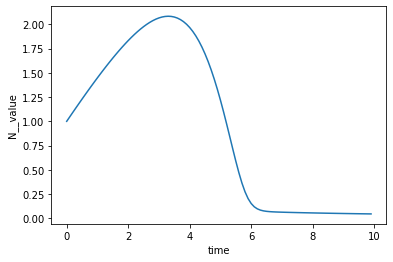

In [30]:
out_ds.N__value.plot.line(x='time')